In [73]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize
import statsmodels.api as sm


# Setup

In [75]:
from pybaseball.lahman import batting
from pybaseball.lahman import pitching

# Get the data
batting_data = batting()
pitching_data = pitching()

# Add player's name
def add_name(ID):
    _player = _players.loc[_players.key_bbref.isin([ID]),:]
    if not _player.empty:
        try:
            fname = _player.name_first.item().capitalize() #if type(_player.name_first.item())==str  else "NaN "
            lname = _player.name_last.item().capitalize() #if type(_player.name_last.item())==str  else "NaN "
            name = fname + ' ' + lname
        except:
            print(_player)

    else:
        name = " "
    return  name

# Get names of players
_players = pybaseball.playerid_reverse_lookup(batting_data.playerID.tolist(),key_type='bbref')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Remove unneeded columns
rows_to_keep = (batting_data.AB>0) #& (batting_data.lgID == "NL") & (batting_data.yearID > 1980)
cols_to_keep = ["AB","H","2B","3B","HR","playerID","yearID"]

# There are multiple rows for each player so group by player and get total H and AB, and take mean of years
bd = batting_data.loc[rows_to_keep ,cols_to_keep].groupby(by="playerID",as_index=True).agg({"AB": "sum", "H": "sum", "2B": "sum", "3B": "sum", "HR": "sum", "yearID": "mean"}).reset_index()#.sum().reset_index()
bd.loc[:,"yearID"] = bd.loc[:,"yearID"].astype("float")

# Add singles and non-hits to DF
bd.loc[:,"1B"] = bd.loc[:,'H'] - bd.loc[:,['2B','3B','HR']].sum(axis=1)
bd.loc[:,"Non-hit"] = bd.loc[:,'AB'] - bd.loc[:,'H']

# Add the player's name for ease of reading
bd["Name"] = bd.apply(lambda row: add_name(row.playerID),axis=1)

# Add batting average
bd["Avg"] = bd.H / bd.AB

# Add slugging percentage 
bd.loc[:,"Slg"] = (bd.loc[:,"1B"] + 2*bd.loc[:,"2B"] + 3*bd.loc[:,"3B"] + 4*bd.loc[:,"HR"])/bd.loc[:,"AB"] 

# Is pitcher?
bd.loc[:,"Pitcher"] = bd.playerID.isin(pitching_data.loc[pitching_data.G > 3,"playerID"])

# Change order
bd = bd.loc[:,["playerID","Name","yearID","AB","Non-hit","H","1B","2B","3B","HR","Avg","Slg","Pitcher"]]

# Check out the DF
bd.sample(10)

,playerID,Name,yearID,AB,Non-hit,H,1B,2B,3B,HR,Avg,Slg,Pitcher
5967,gosseph01,Philip Gosselin,2016.400000,689,509,180,133,35,2,10,0.261248,0.361393,False
14999,speiech01,Chris Speier,1980.227273,7156,5397,1759,1295,302,50,112,0.245808,0.348938,False
16636,warwibi01,Bill Warwick,1924.000000,56,39,17,13,1,2,1,0.303571,0.446429,False
7711,jansera01,Ray Jansen,1910.000000,5,1,4,4,0,0,0,0.800000,0.800000,False
7590,iorgga01,Garth Iorg,1982.888889,2450,1817,633,472,125,16,20,0.258367,0.346939,False
3538,curtier01,Jim Curtiss,1891.000000,211,156,55,43,6,5,1,0.260664,0.350711,False
16329,veachpe01,Peek-a-boo Veach,1887.750000,353,277,76,55,12,6,3,0.215297,0.308782,True
1651,brady01,Spike Brady,1875.000000,4,3,1,0,0,1,0,0.250000,0.750000,False
11086,moronje01,Jeff Moronko,1985.500000,30,26,4,3,1,0,0,0.133333,0.166667,False
1976,buchabr01,Brian Buchanan,2002.285714,767,569,198,126,37,3,32,0.258149,0.439374,False


## Figure 10.1
Percentages of each players’ hits that are made up of singles, doubles, triples, or home runs.

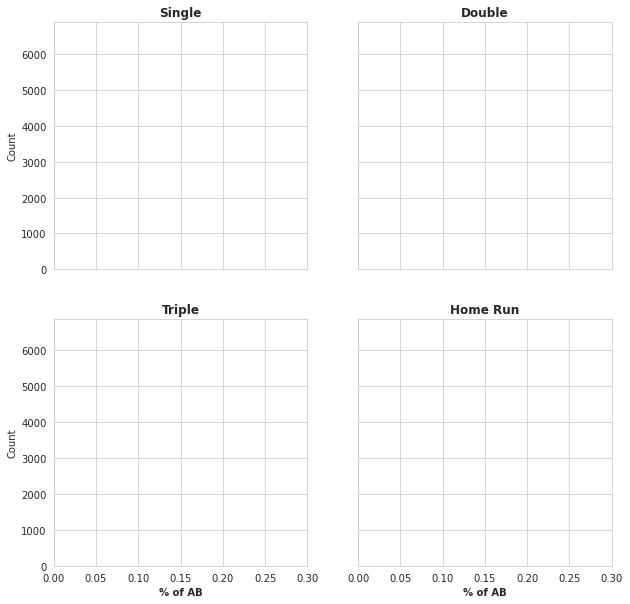

In [76]:
min_atbat=20
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2,sharey=True,sharex=True)
    # flatax = ax.flatten()
    fig.set_size_inches(10,10)

    for cnt,(ax,hittype,name,bins) in enumerate(zip(allax.flatten(),['1B','2B','3B','HR'],["Single","Double","Triple","Home Run"],[20,10,5,10])):
        sns.histplot(bd.loc[bd.H>min_atbat,hittype].count()/bd.loc[bd.H>min_atbat,"AB"],bins=bins,ax=ax,color='k')
        ax.set_xlim(0,0.3)
        ax.set_title(name,fontweight="bold")
        ax.set_xlabel("% of AB",fontweight="bold")
        

Lets check out the leaders in slugging %..

In [77]:
bd.sort_values(by="Slg",ascending=False).head(10)

,playerID,Name,yearID,AB,Non-hit,H,1B,2B,3B,HR,Avg,Slg,Pitcher
9193,lindsch02,Charlie Lindstrom,1958.0,1,0,1,0,0,1,0,1.0,3.0,False
2290,cammaer01,Eric Cammack,2000.0,1,0,1,0,0,1,0,1.0,3.0,True
11241,munnisc01,Scott Munninghoff,1980.0,1,0,1,0,0,1,0,1.0,3.0,True
13506,rodried01,Eduardo Rodriguez,1973.0,1,0,1,0,0,1,0,1.0,3.0,True
17414,yanes01,Esteban Yan,2001.5,2,0,2,1,0,0,1,1.0,2.5,True
11725,oconnfr01,,1893.0,2,0,2,1,0,0,1,1.0,2.5,False
9488,lutzre01,Red Lutz,1922.0,1,0,1,0,1,0,0,1.0,2.0,False
3945,devinha01,Hal Deviney,1920.0,2,0,2,1,0,1,0,1.0,2.0,False
4451,eddydo01,Don Eddy,1971.0,1,0,1,0,1,0,0,1.0,2.0,True
11256,muntesc01,Scott Munter,2006.0,1,0,1,0,1,0,0,1.0,2.0,True


## 10.2 The Dirichlet-multinomial distribution


### 10.2.1 Multinomial distribution

In [78]:
experiment = np.random.multinomial(100, 5*[0.2],(1,3))
pd.DataFrame({"1":experiment[0][0],"2":experiment[0][1],"3":experiment[0][2]})

,1,2,3
0,16,19,16
1,13,19,24
2,25,19,19
3,20,23,21
4,26,20,20


Lets do it again with different probabilities:

In [79]:
experiment = np.random.multinomial(100, [.05, .05, .2, .2, .5],(1,3))
pd.DataFrame({"1":experiment[0][0],"2":experiment[0][1],"3":experiment[0][2]})

,1,2,3
0,4,8,2
1,4,6,6
2,28,19,17
3,21,23,25
4,43,44,50


### 10.2.2 Dirichlet distribution


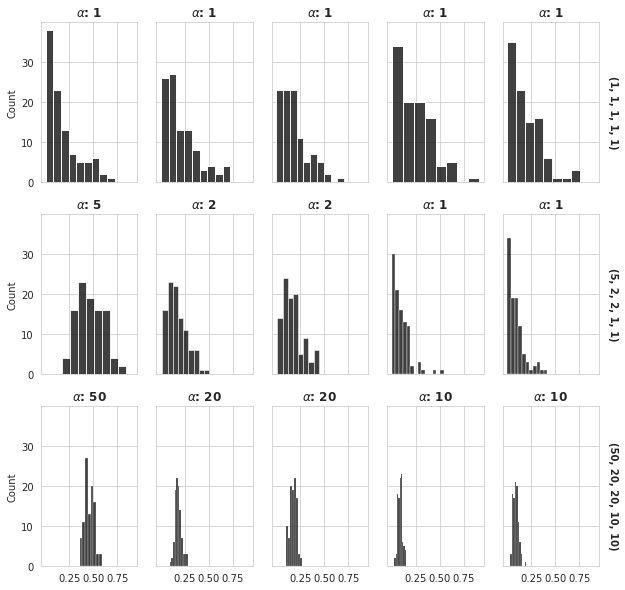

In [80]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(3,5,sharey=True,sharex=True)
#     flatax = ax.flatten()
    fig.set_size_inches(10,10)
    
    alphas = [(1, 1, 1, 1, 1),(5, 2, 2, 1, 1),(50, 20, 20, 10, 10)]
    
    for ii,alpha in enumerate(alphas):
        experiment = np.random.dirichlet(alpha,(1,100))#_000_000))
        for jj in range(ax.shape[1]):
                sns.histplot(experiment[0][:,jj],ax=ax[ii,jj],color='k')
                ax[ii,jj].set_xticks([.25,.5,0.75])
                ax[ii,jj].set_title(r"$\alpha$: {}".format(alpha[jj]),fontweight="bold")

        ax[ii,jj].text(x=1.05,y=17.5,s="{}".format(alpha),va="center",rotation=-90,fontweight="bold")
        
        experiment[0][:,0] # <-- access first column
# pd.DataFrame({"1":experiment[0][0],"2":experiment[0][1],"3":experiment[0][2]})

### 10.2.3 Fitting a Dirichlet-multinomial distribution

There is no built-in way to fit a Dirichlet-multinomial in python. Instead I will use this iterative approach to estimate the parameters from a researcher at Microsoft ([paper](https://tminka.github.io/papers/dirichlet/minka-dirichlet.pdf)).

In [81]:
from scipy.special import digamma

# def estimate_alphas_DirichletMultinomial(data,): 

# Get data
data = bd.loc[:,['1B','2B','3B','HR','Non-hit']].to_numpy()

# Get k --> number of counts
k = data.shape[1]
N = data.sum(1)

# Initialize alpha
alpha     = [35,8,1.8,2.8,138]#50*np.ones((1,k))[0]#
alpha_new = np.ones_like(alpha)

# Define criterion for convergence
min_difference = 10**-10
alpha_diff     = 1
# While convergence is not achieved
cnt = 0
while (alpha_diff > min_difference):
    # Sum across alphas
    alpha_sum = np.sum(alpha)
    denom = np.sum(digamma(N + alpha_sum) - digamma(alpha_sum))
    for kk in range(k):
        # Get numerator
        numer = np.sum(digamma(data[:,kk]+alpha[kk]) - digamma(alpha[kk]))
        # Compute new alphas
        alpha_new[kk] = alpha[kk]*(numer/denom)
    print(alpha_diff )
    # Compute difference
    alpha_diff = np.sum(np.abs(alpha_new-alpha))
    alpha_old = alpha
    alpha = alpha_new
    cnt+=1

# print(cnt,alpha,alpha_old)
        


1
4.7032286184295895


### Figure 10.3
The density of the Dirichlet distribution compared to the histogram of percentages for each type of hit.

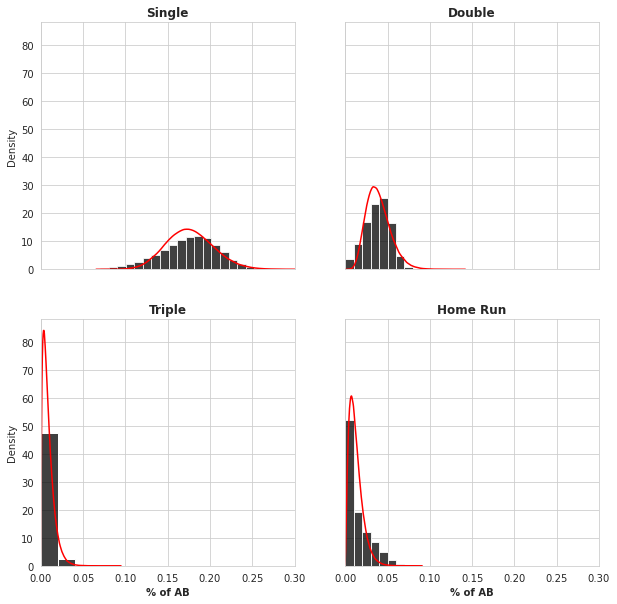

In [82]:
# Minimum number of at bats
min_atbat=20

# Sample from dirichlet using alphas
rvs = pd.DataFrame(stats.dirichlet.rvs(alpha = alpha, size = 1_000_000),columns=['1B','2B','3B','HR','Non-hits'])#[35,8,1.8,2.8,138]

with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    for cnt,(ax,hittype,name,bins) in enumerate(zip(allax.flatten(),['1B','2B','3B','HR'],["Single","Double","Triple","Home Run"],[30,10,5,10])):
        sns.histplot(bd.loc[bd.H>min_atbat,hittype]/bd.loc[bd.H>min_atbat,"AB"],bins=bins,ax=ax,color='k',stat="density")
        sns.kdeplot(rvs.loc[:,hittype],color='r',ax=ax)
        ax.set_xlim(0,0.3)
        ax.set_title(name,fontweight="bold")
        ax.set_xlabel("% of AB",fontweight="bold")
        

Now lets try this with PyMC since those results don't look great..

In [83]:
import pymc as pm
import arviz as az

# Load data or rerun model?
load_params = True

if load_params:
    # Load beta parameters
    with open("./data/eb_estimate_dirichletmultinomial_params.npy","rb") as f:
        alpha = np.load(f)    
else:
    # this is a reparamerization of the Dirichlet-Multinomial
    with pm.Model() as model:
        frac = pm.Dirichlet("frac", a=np.ones(k))
        conc = pm.Lognormal("conc", mu=1, sigma=1)
        counts = pm.DirichletMultinomial("counts", a=frac*conc,n=data.sum(1),shape=data.shape, observed=data)
        trace = pm.sample(10_000, chains=4, return_inferencedata=True)

        az.plot_trace(data=trace, var_names=["frac", "conc"])

        alpha = trace["posterior"]["frac"].mean(("chain","draw")).to_numpy() * trace["posterior"]["conc"].mean(("chain","draw")).to_numpy()

        # Save beta parameters
        with open("./data/eb_estimate_dirichletmultinomial_params.npy","wb") as f:
            np.save(f,alpha)


array([[<AxesSubplot:title={'center':'frac'}>,
        <AxesSubplot:title={'center':'frac'}>],
       [<AxesSubplot:title={'center':'conc'}>,
        <AxesSubplot:title={'center':'conc'}>]], dtype=object)

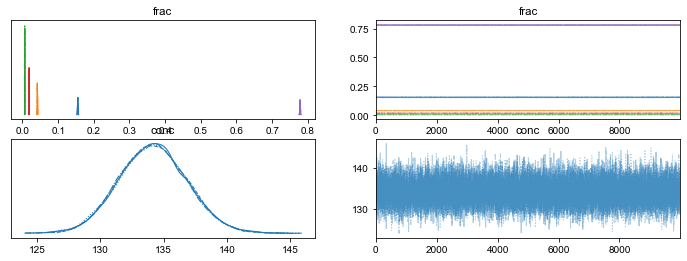

In [84]:
az.plot_trace(data=trace, var_names=["frac", "conc"])

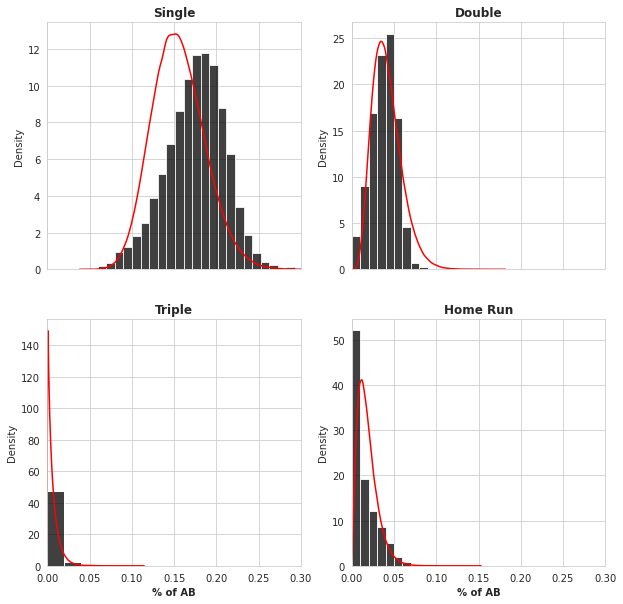

In [85]:
alpha = trace["posterior"]["frac"].mean(("chain","draw")).to_numpy() * trace["posterior"]["conc"].mean(("chain","draw")).to_numpy()

# Minimum number of at bats
min_atbat=20

# Sample from dirichlet using alphas
rvs = pd.DataFrame(stats.dirichlet.rvs(alpha = alpha, size = 1_000_000),columns=['1B','2B','3B','HR','Non-hits'])#[35,8,1.8,2.8,138]

with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2,sharey=False,sharex=True)
    fig.set_size_inches(10,10)
    for cnt,(ax,hittype,name,bins) in enumerate(zip(allax.flatten(),['1B','2B','3B','HR'],["Single","Double","Triple","Home Run"],[30,10,5,10])):
        sns.histplot(bd.loc[bd.H>min_atbat,hittype]/bd.loc[bd.H>min_atbat,"AB"],bins=bins,ax=ax,color='k',stat="density")
        sns.kdeplot(rvs.loc[:,hittype],color='r',ax=ax)
        ax.set_xlim(0,0.3)
        ax.set_title(name,fontweight="bold")
        ax.set_xlabel("% of AB",fontweight="bold")


In [93]:
def update_posterior_DirichletMultinomial(row,alphas):
    # Multiply hits/nonhits by alphas
    eb_hits = np.add(row[['1B','2B','3B','HR','Non-hit']].to_numpy(), alphas)
    # Compute updated sluggin percentage
    row["Slg_eb_estimate"] = np.sum(np.multiply(eb_hits[0:-1],[1,2,3,4]))/(row.AB + np.sum(alphas))
    return row

bd = bd.apply(lambda row: update_posterior_DirichletMultinomial(row,alpha),axis=1).sort_values(by="Slg_eb_estimate",ascending=False)

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_72910/26458709.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(splot,ticks=cbar_ticks)


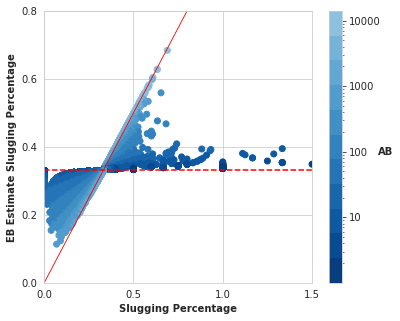

In [103]:
import matplotlib as mpl

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot()
    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])
    # Plot scatter 
    splot = ax.scatter(bd["Slg"],bd["Slg_eb_estimate"],c=bd["AB"],cmap=cmap,norm=mpl.colors.LogNorm())
    # Plot x=y
    ax.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),color='r',lw=0.85)
    # Plot pure eb estimate
    ax.axhline(y=(np.sum(np.multiply(alpha[:-1],[1,2,3,4]))/np.sum(alpha)),color='r',linestyle='--')
    # Clean up
    cbar_ticks = [0,10,100,1000,10000]
    cbar = plt.colorbar(splot,ticks=cbar_ticks)
    cbar.ax.set_yticklabels(list(map(str, cbar_ticks)))
    cbar.set_label("AB",rotation=0,fontweight="bold")
    ax.set_ylim(0,0.8)
    ax.set_xlim(0,1.5)
    ax.set_yticks([0,0.2,0.4,0.6,0.8])
    ax.set_xticks([0,0.5,1,1.5])
    ax.set_xlabel("Slugging Percentage",fontweight="bold")
    ax.set_ylabel("EB Estimate Slugging Percentage",fontweight="bold")

Lets try a slight variation....

In [90]:
# with pm.Model() as model:
#     # make the Dirichlet an uninformative prior
#     alpha_D = np.ones(k)
#     # choose true proportions
#     p = pm.Dirichlet("p", a=alpha_D)
#     # choose a number of ABs
#     alpha_G = pm.Exponential('alpha', 10)
#     beta_G  = pm.Exponential('beta', 100)
#     n = pm.Gamma("n",alpha=alpha_G,beta=beta_G,observed=bd.loc[:,"AB"])
#     # n = pm.DiscreteUniform("n", lower=40, upper=100, observed=df.sum(axis=1).values)
#     # choose how many of each color to put in that bag adding up to n based on proportions p
#     m = pm.Multinomial("m", n=n, p=p, observed=data)
    
#     trace = pm.sample(2500)

In [91]:
# az.plot_trace(data=trace)

In [92]:

# alphas = trace["posterior"]["p"].mean(("chain","draw")).to_numpy() 
# alpha_mean = trace["posterior"]["alpha"].mean(("chain","draw")).to_numpy() 
# beta_mean  = trace["posterior"]["beta"].mean(("chain","draw")).to_numpy()

# # with sns.axes_style("whitegrid"):
# #     fig = plt.figure(figsize=(6,5))
# #     ax = fig.add_subplot()

# #     sns.histplot(bd.loc[:,"AB"],ax=ax,stat="density")
# #     ax.plot(np.arange(0,12000,1),stats.gamma.pdf(np.arange(0,12000,1), a=alph, scale=1/bet),color='r',lw=0.5)
# #     ax.set_ylim(0,0.005)

Now we need to compute the EB estimate for Slugging percentage for all players. 